<a href="https://colab.research.google.com/github/spadrejuan/ml-final-project/blob/Fabian-Branch/Fabian_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### For Google Colab to import Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

## Convert JPG to JPEG

In [237]:
import cv2
import os
from pathlib import Path

# # For VSC
# DATA_DIR = "dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

# For Google Colab
DATA_DIR = "drive/MyDrive/dataset (1)/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

def jpg_to_jpeg(data_dir):
    for dir_name in os.listdir(data_dir):
        files = os.path.join(data_dir,dir_name)
        for filepaths in os.listdir(files):
            file_names = os.path.join(files,filepaths)
            if file_names.endswith(".jpg") or file_names.endswith(".JPG"):
                img = cv2.imread(str(file_names))
                cv2.imwrite(file_names[0:-4]+".jpeg", img)
                os.remove(file_names)

In [238]:
import imghdr

IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

# Import Tensorflow and Keras

In [239]:
import tensorflow as tf
import keras

BATCH_SIZE = 64
HEIGHT = 256
WIDTH = 256
IMAGE_SIZE = (HEIGHT, WIDTH)

# Preprocessing

In [240]:
def load_dataset(path):
    all_files = [os.path.join(path, f) for f in os.listdir(path)]
    valid_files = [f for f in all_files if f.split('.')[-1].lower() in img_type_accepted_by_tf]
    return tf.data.Dataset.from_tensor_slices(valid_files)

def split_dataset(dataset, train_size, val_size):
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    return train_dataset, val_dataset

def undersample_dataset(dataset, target_size):
    return dataset.take(target_size)

def load_and_preprocess_image(file_path):
    file_extension = tf.strings.split(file_path, '.')[-1]
    image = tf.io.read_file(file_path)

    # Decode based on the file extension
    if file_extension == 'png':
        image = tf.image.decode_png(image, channels=3)
    elif file_extension == 'bmp':
        image = tf.image.decode_bmp(image, channels=3)
    elif file_extension == 'gif':
        image = tf.image.decode_gif(image)
        image = tf.squeeze(image, axis=0)  # Extract the first frame
    else:  # Default to JPEG
        image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    return image

def label_dataset(dataset, label):
    return dataset.map(lambda x: (x, label))

In [241]:
# AI_ART_PATH = 'dataset/AI Art vs Real Art/AI Art/AiArtData'
# REAL_ART_PATH = 'dataset/AI Art vs Real Art/Real/RealArt'
AI_ART_PATH = '/content/drive/MyDrive/dataset (1)/AI Art vs Real Art/AI Art/AiArtData'
REAL_ART_PATH = '/content/drive/MyDrive/dataset (1)/AI Art vs Real Art/Real/RealArt'
ai_images = load_dataset(AI_ART_PATH)
real_images = load_dataset(REAL_ART_PATH)

ai_dataset = ai_images.shuffle(buffer_size=1000, seed=1337)
real_dataset = real_images.shuffle(buffer_size=1000, seed=1337)

In [242]:
num_of_ai = len(os.listdir(AI_ART_PATH))
num_of_real = len(os.listdir(REAL_ART_PATH))
print(f'Total Number of Images: {num_of_ai + num_of_real} \nNumber of AI: {num_of_ai} \nNumber of Real: {num_of_real}')

ai_train_size = int(num_of_ai * 0.8) # 0.8 split
ai_val_size = num_of_ai - ai_train_size

real_train_size = int(num_of_real * 0.8)
real_val_size = num_of_real - real_train_size

Total Number of Images: 916 
Number of AI: 506 
Number of Real: 410


In [243]:
ai_train_dataset, ai_val_dataset = split_dataset(ai_dataset, ai_train_size, ai_val_size)
real_train_dataset, real_val_dataset = split_dataset(real_dataset, real_train_size, real_val_size)

target_train_size = min(ai_train_size, real_train_size)
target_val_size = min(ai_val_size, real_val_size)

print(f'Target Sizes of Training: {target_train_size} for Train, and {target_val_size} for Validation')

Target Sizes of Training: 328 for Train, and 82 for Validation


In [244]:
ai_train_dataset = undersample_dataset(ai_train_dataset, target_train_size)
real_train_dataset = undersample_dataset(real_train_dataset, target_train_size)

ai_val_dataset = undersample_dataset(ai_val_dataset, target_val_size)
real_val_dataset = undersample_dataset(real_val_dataset, target_val_size)

In [245]:
ai_train_dataset= ai_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
real_train_dataset = real_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ai_val_dataset =ai_val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
real_val_dataset = real_val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [246]:
ai_train_dataset = label_dataset(ai_train_dataset, 0)
real_train_dataset = label_dataset(real_train_dataset, 1)

ai_val_dataset = label_dataset(ai_val_dataset, 0)
real_val_dataset = label_dataset(real_val_dataset, 1)

In [247]:
train_dataset = ai_train_dataset.concatenate(real_train_dataset)
train_dataset = train_dataset.shuffle(buffer_size=1000)

val_dataset = ai_val_dataset.concatenate(real_val_dataset)
val_dataset = val_dataset.shuffle(buffer_size=1000)

In [248]:
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Display sample images

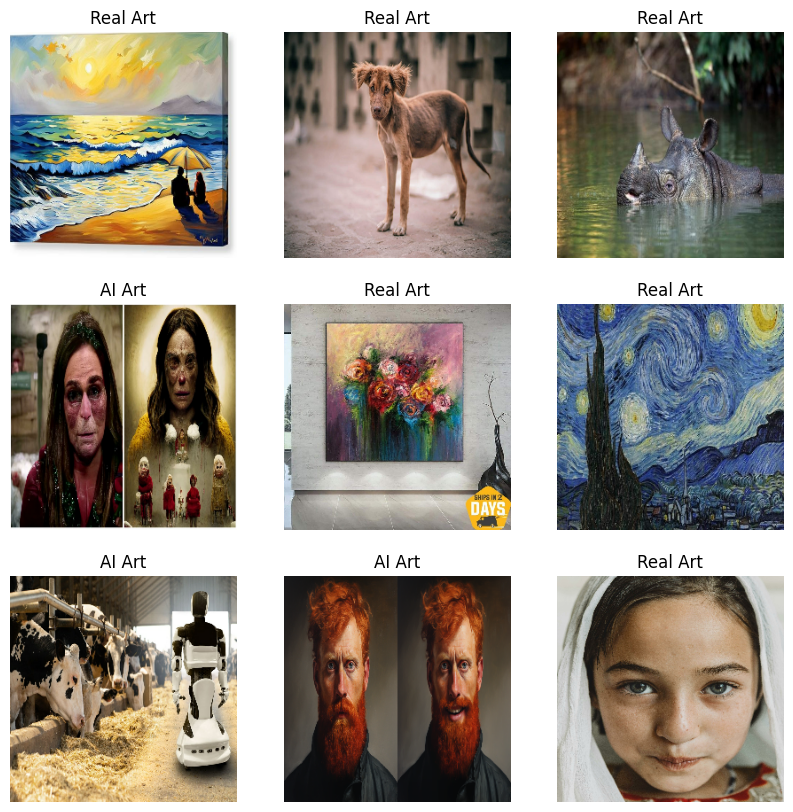

In [249]:
import matplotlib.pyplot as plt

def display_binary_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i].numpy())])
            plt.axis("off")

class_names = ['AI Art', 'Real Art']

display_binary_images(train_dataset, class_names)

In [250]:
from tensorflow import data as tf_data

train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE).cache()
val_dataset = val_dataset.prefetch(tf_data.AUTOTUNE).cache()


## Base Model

In [251]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
import numpy as np

# Load the model pre-trained on ImageNet data
base_model = tf.keras.applications.VGG16(input_shape=(HEIGHT, WIDTH, 3), include_top=False, weights='imagenet')

# Add custom classification head
x = GlobalMaxPooling2D()(base_model.output)
X = Flatten()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Using sigmoid for binary classification

# Combine the base model with the custom classification head
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model except for the last few
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers for fine-tuning
for layer in model.layers[-3:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
              loss='binary_crossentropy',
              metrics=[keras.metrics.BinaryAccuracy()])




In [252]:
EPOCHS = 10  # Number of epochs for training

In [253]:
# Define Learning Rate Scheduling callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.2,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1             # Print message when learning rate is reduced
)

# Define Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Print message when training is stopped
    restore_best_weights=True  # Restore model weights to the point of best validation loss
)

In [254]:
# Train the model
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[lr_scheduler, early_stopping]
                    )


Epoch 1/10
11/11 [==============================] - 21s 862ms/step - loss: 12.4992 - binary_accuracy: 0.5046 - val_loss: 3.1095 - val_binary_accuracy: 0.5215 - lr: 1.0000e-04
Epoch 2/10
11/11 [==============================] - 4s 387ms/step - loss: 1.1426 - binary_accuracy: 0.7271 - val_loss: 0.7307 - val_binary_accuracy: 0.7607 - lr: 1.0000e-04
Epoch 3/10
11/11 [==============================] - 4s 386ms/step - loss: 0.4470 - binary_accuracy: 0.8247 - val_loss: 0.8980 - val_binary_accuracy: 0.7055 - lr: 1.0000e-04
Epoch 4/10
11/11 [==============================] - 4s 401ms/step - loss: 0.7128 - binary_accuracy: 0.7378 - val_loss: 0.2474 - val_binary_accuracy: 0.9018 - lr: 1.0000e-04
Epoch 5/10
11/11 [==============================] - 4s 396ms/step - loss: 0.9097 - binary_accuracy: 0.7851 - val_loss: 2.3365 - val_binary_accuracy: 0.5460 - lr: 1.0000e-04
Epoch 6/10
11/11 [==============================] - 4s 404ms/step - loss: 1.0358 - binary_accuracy: 0.7348 - val_loss: 0.1948 - val_b

## Fine-Tuning 1

In [255]:
# Unfreeze specific layers in the base model
# Here, we unfreeze the convolutional blocks corresponding to 'conv2' and 'conv4'
for layer in base_model.layers:
    if layer.name.startswith('conv2') or layer.name.startswith('conv4'):
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-6),  # Very low learning rate
              loss='binary_crossentropy',
              metrics=[keras.metrics.BinaryAccuracy()])

In [256]:
# Train the model
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[lr_scheduler, early_stopping]
                    )

Epoch 1/10
11/11 [==============================] - 6s 430ms/step - loss: 0.0056 - binary_accuracy: 1.0000 - val_loss: 0.1301 - val_binary_accuracy: 0.9509 - lr: 1.0000e-06
Epoch 2/10
11/11 [==============================] - 5s 433ms/step - loss: 0.0046 - binary_accuracy: 1.0000 - val_loss: 0.1317 - val_binary_accuracy: 0.9509 - lr: 1.0000e-06
Epoch 3/10
11/11 [==============================] - 4s 389ms/step - loss: 0.0041 - binary_accuracy: 1.0000 - val_loss: 0.1312 - val_binary_accuracy: 0.9509 - lr: 1.0000e-06
Epoch 4/10
11/11 [==============================] - ETA: 0s - loss: 0.0036 - binary_accuracy: 1.0000
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999949504855e-07.
11/11 [==============================] - 4s 384ms/step - loss: 0.0036 - binary_accuracy: 1.0000 - val_loss: 0.1315 - val_binary_accuracy: 0.9509 - lr: 1.0000e-06
Epoch 5/10
11/11 [==============================] - 4s 386ms/step - loss: 0.0033 - binary_accuracy: 1.0000 - val_loss: 0.1317 - val_binary_ac

## Fine-Tuning 2

In [257]:
# Unfreeze specific layers in the base model
# Here, we unfreeze the middle, and last convolutional blocks
for layer in base_model.layers:
    if layer.name.startswith('conv3') or layer.name.startswith('conv5'):
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-7),  # Very low learning rate
              loss='binary_crossentropy',
              metrics=[keras.metrics.BinaryAccuracy()])

In [258]:
# Train the model
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[lr_scheduler, early_stopping]
                    )

Epoch 1/10
11/11 [==============================] - 6s 422ms/step - loss: 0.0048 - binary_accuracy: 1.0000 - val_loss: 0.1300 - val_binary_accuracy: 0.9509 - lr: 1.0000e-07
Epoch 2/10
11/11 [==============================] - 4s 397ms/step - loss: 0.0047 - binary_accuracy: 1.0000 - val_loss: 0.1300 - val_binary_accuracy: 0.9509 - lr: 1.0000e-07
Epoch 3/10
11/11 [==============================] - 5s 429ms/step - loss: 0.0046 - binary_accuracy: 1.0000 - val_loss: 0.1300 - val_binary_accuracy: 0.9509 - lr: 1.0000e-07
Epoch 4/10
11/11 [==============================] - ETA: 0s - loss: 0.0045 - binary_accuracy: 1.0000
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.000000023372195e-08.
11/11 [==============================] - 5s 431ms/step - loss: 0.0045 - binary_accuracy: 1.0000 - val_loss: 0.1300 - val_binary_accuracy: 0.9509 - lr: 1.0000e-07
Epoch 5/10
11/11 [==============================] - 4s 394ms/step - loss: 0.0045 - binary_accuracy: 1.0000 - val_loss: 0.1300 - val_binary_acc